In [1]:
import wfdb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
import seaborn as sns
import csv
from matplotlib import cm
from mne.filter import filter_data
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from mne.filter import filter_data, notch_filter
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, auc, recall_score, precision_score, f1_score, confusion_matrix, accuracy_score

matplotlib.rcParams.update({'font.size':30
                            , 'font.family': 'Times New Roman'
                            , 'axes.labelsize': 30
                            , 'axes.titlesize': 30
                            , 'xtick.labelsize': 30
                            , 'ytick.labelsize': 30
                            , 'legend.fontsize': 30
                            , 'figure.titlesize': 30
                            , 'figure.dpi': 300})


all_data_path = r"PAF\coding\lj\all_data"
small_data_path = r"PAF\coding\lj\data"

# file_path = "Net1d_newGroup\PAF_net1d_Group2\list_data.h5"
# file_path = "Net1d_Split\PAF_net1d_Split1_5\list_data.h5"
firstNum = 67
file_path = f"Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-{firstNum}/list_data{firstNum}.h5"
file_paths = ["Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-16\list_data16.h5", "Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-17\list_data17.h5", "Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-43\list_data43.h5", "Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-67\list_data67.h5", "Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-103\list_data103.h5"]

hf_keys = []
data = {}
for file_path in file_paths:
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            hf_keys.append(key)
            data[key] = hf[key][:]
print(hf_keys)
print(len(hf_keys))


people_info = pd.read_csv(r"PAF\coding\data_distil\people_info.csv")
key_value = people_info.set_index('Key').to_dict()['Value']
print(key_value)

['data_12_1', 'data_12_2', 'data_12_3', 'data_12_4', 'data_12_5', 'data_12_6', 'data_12_7', 'data_12_8', 'data_16_1', 'data_16_2', 'data_16_3', 'data_16_4', 'data_22_1', 'data_22_10', 'data_22_11', 'data_22_12', 'data_22_13', 'data_22_14', 'data_22_15', 'data_22_16', 'data_22_2', 'data_22_3', 'data_22_4', 'data_22_5', 'data_22_6', 'data_22_7', 'data_22_8', 'data_22_9', 'data_26_1', 'data_26_10', 'data_26_11', 'data_26_12', 'data_26_13', 'data_26_2', 'data_26_3', 'data_26_4', 'data_26_5', 'data_26_6', 'data_26_7', 'data_26_8', 'data_26_9', 'data_36_1', 'data_36_2', 'data_36_3', 'data_36_4', 'data_36_5', 'data_36_6', 'data_36_7', 'data_36_8', 'data_40_1', 'data_40_2', 'data_40_3', 'data_40_4', 'data_40_5', 'data_41_1', 'data_41_10', 'data_41_11', 'data_41_12', 'data_41_13', 'data_41_14', 'data_41_2', 'data_41_3', 'data_41_4', 'data_41_5', 'data_41_6', 'data_41_7', 'data_41_8', 'data_41_9', 'data_45_1', 'data_45_10', 'data_45_2', 'data_45_3', 'data_45_4', 'data_45_5', 'data_45_6', 'data_4

# Beat Information Fusion Decision

# avg

In [6]:
def afDurationCreate(aux, afDuration):
    seg = []
    for i in range(len(aux)):
        if aux[i] == '(AFIB' or aux[i] == 'AFL':
            if len(seg) == 0:
                seg.append(i)
            else:
                continue
        elif aux[i] == '(N':
            if len(seg) != 0:
                seg.append(i)
            else:
                seg.append(i)
                seg.append(i)
            # seg.append(i)
        if i == len(aux) - 1 and len(seg) == 1:
            seg.append(i)
        if len(seg) == 2:
            afDuration.append(seg)
            seg = []
    if len(afDuration) == 0:
        afDuration.append([0, 0])
def checkInAf(x, afDuration):
    # print(afDuration)
    try:
        for temp in afDuration:
            s, e = temp[0], temp[1]
            if x >= s and x < e:
                return True
        return False
    except:
        print(afDuration)
        print(x)

# targets = ['data_40_1'] # 阵发性房颤:40_1, 31_1, 31_2, 31_6, 31_7, 31_10\11\12\13\14, 39也是
# targets = [f"data_31_{i}" for i in [1, 2, 6, 7, 10, 11, 12, 13, 14]]
testSet1 = [16, 62, 12, 22, 71, 85, 53, 69, 26, 70, 5, 40, 41, 55, 47, 36, 78, 89, 45, 8, 79]
testSet2 = [17, 31, 100, 93, 102, 95, 84, 86, 18, 11, 48, 97, 88, 83, 104, 30, 29, 75, 4, 77, 37]
testSet3 = [43, 1, 49, 72, 25, 73, 44, 76, 7, 66, 32, 46, 42, 21, 14, 63, 94, 87, 33, 19, 74]
testSet4 = [67, 15, 61, 96, 24, 9, 59, 91, 6, 0, 65, 81, 10, 20, 82, 99, 92, 35, 101, 27, 52]
testSet5 = [103, 50, 64, 28, 68, 80, 90, 51, 98, 39, 3, 56, 58, 60, 54, 34, 38, 23, 13, 2, 57]

# len(hf_keys): 1435
# targets = [f"data_39_{i}" for i in range(1, 23)]
# targets = ['data_88_4']
testSets = [testSet1, testSet2, testSet3, testSet4, testSet5]
for testSet in testSets:
    avg_labels = []
    avg_pro = []
    for target in hf_keys:
        if int(target.split('_')[1]) not in testSet:
            continue
        file_name = target
        record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
        sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
        label = key_value[int(target.split('_')[1])]
        # if label == 0:
        #     continue

        annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
        R_location = annotation.sample
        R_symbol = annotation.symbol
        aux = annotation.aux_note
        p_signal = record.p_signal[:, 0]
        p_signal = p_signal.flatten()
        # print("R_symbol: ", R_symbol)

        # 滤波操作
        sfreq = 200
        low_freq = 0.5
        high_freq = 50.0
        p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

        # 获得概率值
        seg_data = data[target]
        # print(seg_data.shape)
        seg_pro = []
        for i in range(len(seg_data)):
            seg_pro.append(round(seg_data[i][-2], 2))
        
        # AF_location = []
        # for i in range(len(R_symbol))[10:-5]:
        #     if R_symbol[i] != 'N':
        #         AF_location.append(i+1)
        
        afDuration = []
        afDurationCreate(aux, afDuration)

        # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
        all_seg_pro = [0 for i in range(10)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                all_seg_pro.append(seg_pro[index])
                index += 1
            else:
                all_seg_pro.append(1)
        # print("index: ", index)
        
        #  splitNum个beat分桶
        # tonNum = 20
        # splitNum = len(R_symbol) // tonNum
        splitNum = 250
        if splitNum == 0:
            splitNum = 1
        areasplitNum = [[] for i in range(len(R_symbol) // splitNum + 1)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                areasplitNum[i // splitNum].append(seg_pro[index])
                index += 1
        # print("len(areasplitNum):", len(areasplitNum))
        
        avgsplitNum = []
        for i in range(len(areasplitNum)):
            avgsplitNum.append(np.mean(areasplitNum[i]))
            if not np.isnan(np.mean(areasplitNum[i])):
                avg_labels.append(label)
                avg_pro.append(np.mean(areasplitNum[i]))
                # print("np.mean(areasplitNum[i]): ", np.mean(areasplitNum[i]))
        # print("len(avgsplitNum): ", len(avgsplitNum))
        # print("avgsplitNum: ", avgsplitNum)


    all_labels = np.array(avg_labels)
    all_probabilities = np.array(avg_pro)

    binary_predictions = [1 if prob >= 0.5 else 0 for prob in all_probabilities]
    # print("name: ", name)
    # print("real label 1 num, 0 num: ", label.count(1), " ", label.count(0))
    # print("predict 1 num, 0 num: ", binary_predictions.count(1), " ", binary_predictions.count(0))

    acc = accuracy_score(all_labels, binary_predictions)
    recall = recall_score(all_labels, binary_predictions)
    precision = precision_score(all_labels, binary_predictions)
    f1 = f1_score(all_labels, binary_predictions)
    auc = roc_auc_score(all_labels, all_probabilities)

    # 计算ROC曲线
    # fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    # roc_auc = auc(fpr, tpr)
    
    # 绘制ROC曲线
    # plt.figure()
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    # plt.legend(loc="lower right")

    # print("roc_auc_score:", roc_auc_score(all_labels, all_probabilities))
    # print("recall_score:", recall_score(all_labels, np.round(all_probabilities)))
    # print("precision_score:", precision_score(all_labels, np.round(all_probabilities)))
    # print("f1_score:", f1_score(all_labels, np.round(all_probabilities)))
    # print("confusion_matrix:\n", confusion_matrix(all_labels, np.round(all_probabilities)))
    # if not os.path.exists("./DenoiseResult/beatInforDecision"):
    #     os.makedirs("./DenoiseResult/beatInforDecision")
    # plt.tight_layout()
    # plt.savefig(f"./DenoiseResult/beatInforDecision/roc_auc{testSet[0]}.png")

    # 将结果写入CSV文件
    if not os.path.exists("./DenoiseResult/beatInforDecision"):
        os.makedirs("./DenoiseResult/beatInforDecision")
    with open(f'./DenoiseResult/beatInforDecision/splitNumAvg{splitNum}.csv', mode='a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # 如果文件不存在，写入表头
        if csvfile.tell() == 0:
            writer.writerow(['Index', 'Accuracy', 'Recall', 'Precision', 'F1', 
                            'AUC', 
                            'Num'])
        writer.writerow([testSet[0],
                        round(acc*100, 2), 
                        round(recall*100, 2), 
                        round(precision*100, 2), 
                        round(f1*100, 2), 
                        round(auc*100, 2), 
                        len(all_labels)])
# 求平均值
folderPath = f"./DenoiseResult/beatInforDecision/splitNumAvg{splitNum}.csv"
df = pd.read_csv(folderPath)
avgValues = df.mean()
avgDf = pd.DataFrame({"Index": ["Avg"],
                        "Accuracy": [round(avgValues["Accuracy"], 2)],
                        "Recall": [round(avgValues['Recall'], 2)],
                        "Precision": [round(avgValues['Precision'], 2)],
                        "F1": [round(avgValues["F1"], 2)],
                        "AUC": [round(avgValues["AUC"], 2)],
                        "Num": [round(avgValues["Num"], 2)]})
resultDf = pd.concat([df, avgDf], ignore_index=True)
resultDf.to_csv(folderPath, index=False)

d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=

# max

In [45]:
def afDurationCreate(aux, afDuration):
    seg = []
    for i in range(len(aux)):
        if aux[i] == '(AFIB' or aux[i] == 'AFL':
            if len(seg) == 0:
                seg.append(i)
            else:
                continue
        elif aux[i] == '(N':
            if len(seg) != 0:
                seg.append(i)
            else:
                seg.append(i)
                seg.append(i)
            # seg.append(i)
        if i == len(aux) - 1 and len(seg) == 1:
            seg.append(i)
        if len(seg) == 2:
            afDuration.append(seg)
            seg = []
    if len(afDuration) == 0:
        afDuration.append([0, 0])
def checkInAf(x, afDuration):
    # print(afDuration)
    try:
        for temp in afDuration:
            s, e = temp[0], temp[1]
            if x >= s and x < e:
                return True
        return False
    except:
        print(afDuration)
        print(x)

# targets = ['data_40_1'] # 阵发性房颤:40_1, 31_1, 31_2, 31_6, 31_7, 31_10\11\12\13\14, 39也是
# targets = [f"data_31_{i}" for i in [1, 2, 6, 7, 10, 11, 12, 13, 14]]
testSet1 = [16, 62, 12, 22, 71, 85, 53, 69, 26, 70, 5, 40, 41, 55, 47, 36, 78, 89, 45, 8, 79]
testSet2 = [17, 31, 100, 93, 102, 95, 84, 86, 18, 11, 48, 97, 88, 83, 104, 30, 29, 75, 4, 77, 37]
testSet3 = [43, 1, 49, 72, 25, 73, 44, 76, 7, 66, 32, 46, 42, 21, 14, 63, 94, 87, 33, 19, 74]
testSet4 = [67, 15, 61, 96, 24, 9, 59, 91, 6, 0, 65, 81, 10, 20, 82, 99, 92, 35, 101, 27, 52]
testSet5 = [103, 50, 64, 28, 68, 80, 90, 51, 98, 39, 3, 56, 58, 60, 54, 34, 38, 23, 13, 2, 57]

# len(hf_keys): 1435
# targets = [f"data_39_{i}" for i in range(1, 23)]
# targets = ['data_88_4']
testSets = [testSet1, testSet2, testSet3, testSet4, testSet5]
for testSet in testSets:
    avg_labels = []
    avg_pro = []
    for target in hf_keys:
        if int(target.split('_')[1]) not in testSet:
            continue
        file_name = target
        record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
        sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
        label = key_value[int(target.split('_')[1])]
        # if label == 0:
        #     continue

        annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
        R_location = annotation.sample
        R_symbol = annotation.symbol
        aux = annotation.aux_note
        p_signal = record.p_signal[:, 0]
        p_signal = p_signal.flatten()
        # print("R_symbol: ", R_symbol)

        # 滤波操作
        sfreq = 200
        low_freq = 0.5
        high_freq = 50.0
        p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

        # 获得概率值
        seg_data = data[target]
        # print(seg_data.shape)
        seg_pro = []
        for i in range(len(seg_data)):
            seg_pro.append(round(seg_data[i][-2], 2))
        
        # AF_location = []
        # for i in range(len(R_symbol))[10:-5]:
        #     if R_symbol[i] != 'N':
        #         AF_location.append(i+1)
        
        afDuration = []
        afDurationCreate(aux, afDuration)

        # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
        all_seg_pro = [0 for i in range(10)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                all_seg_pro.append(seg_pro[index])
                index += 1
            else:
                all_seg_pro.append(1)
        # print("index: ", index)
        
        #  splitNum个beat分桶
        # tonNum = 20
        # splitNum = len(R_symbol) // tonNum
        splitNum = 50
        if splitNum == 0:
            splitNum = 1
        areasplitNum = [[] for i in range(len(R_symbol) // splitNum + 1)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                areasplitNum[i // splitNum].append(seg_pro[index])
                index += 1
        # print("len(areasplitNum):", len(areasplitNum))
        
        avgsplitNum = []
        for i in range(len(areasplitNum)):
            avgsplitNum.append(np.mean(areasplitNum[i]))
            if not np.isnan(np.mean(areasplitNum[i])):
                avg_labels.append(label)
                avg_pro.append(np.max(areasplitNum[i]))
                # print("np.mean(areasplitNum[i]): ", np.mean(areasplitNum[i]))
        # print("len(avgsplitNum): ", len(avgsplitNum))
        # print("avgsplitNum: ", avgsplitNum)


    all_labels = np.array(avg_labels)
    all_probabilities = np.array(avg_pro)

    binary_predictions = [1 if prob >= 0.5 else 0 for prob in all_probabilities]
    # print("name: ", name)
    # print("real label 1 num, 0 num: ", label.count(1), " ", label.count(0))
    # print("predict 1 num, 0 num: ", binary_predictions.count(1), " ", binary_predictions.count(0))

    acc = accuracy_score(all_labels, binary_predictions)
    recall = recall_score(all_labels, binary_predictions)
    precision = precision_score(all_labels, binary_predictions)
    f1 = f1_score(all_labels, binary_predictions)
    auc = roc_auc_score(all_labels, all_probabilities)

    # 计算ROC曲线
    # fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    # roc_auc = auc(fpr, tpr)
    
    # 绘制ROC曲线
    # plt.figure()
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    # plt.legend(loc="lower right")

    # print("roc_auc_score:", roc_auc_score(all_labels, all_probabilities))
    # print("recall_score:", recall_score(all_labels, np.round(all_probabilities)))
    # print("precision_score:", precision_score(all_labels, np.round(all_probabilities)))
    # print("f1_score:", f1_score(all_labels, np.round(all_probabilities)))
    # print("confusion_matrix:\n", confusion_matrix(all_labels, np.round(all_probabilities)))
    # if not os.path.exists("./DenoiseResult/beatInforDecision"):
    #     os.makedirs("./DenoiseResult/beatInforDecision")
    # plt.tight_layout()
    # plt.savefig(f"./DenoiseResult/beatInforDecision/roc_auc{testSet[0]}.png")

    # 将结果写入CSV文件
    if not os.path.exists("./DenoiseResult/beatInforDecision"):
        os.makedirs("./DenoiseResult/beatInforDecision")
    with open(f'./DenoiseResult/beatInforDecision/splitNumMax{splitNum}.csv', mode='a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # 如果文件不存在，写入表头
        if csvfile.tell() == 0:
            writer.writerow(['Index', 'Accuracy', 'Recall', 'Precision', 'F1', 
                            'AUC', 
                            'Num'])
        writer.writerow([testSet[0],
                        round(acc*100, 2), 
                        round(recall*100, 2), 
                        round(precision*100, 2), 
                        round(f1*100, 2), 
                        round(auc*100, 2), 
                        len(all_labels)])
# 求平均值
folderPath = f"./DenoiseResult/beatInforDecision/splitNumMax{splitNum}.csv"
df = pd.read_csv(folderPath)
avgValues = df.mean()
avgDf = pd.DataFrame({"Index": ["Avg"],
                        "Accuracy": [round(avgValues["Accuracy"], 2)],
                        "Recall": [round(avgValues['Recall'], 2)],
                        "Precision": [round(avgValues['Precision'], 2)],
                        "F1": [round(avgValues["F1"], 2)],
                        "AUC": [round(avgValues["AUC"], 2)],
                        "Num": [round(avgValues["Num"], 2)]})
resultDf = pd.concat([df, avgDf], ignore_index=True)
resultDf.to_csv(folderPath, index=False)

d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=

# min

In [48]:
def afDurationCreate(aux, afDuration):
    seg = []
    for i in range(len(aux)):
        if aux[i] == '(AFIB' or aux[i] == 'AFL':
            if len(seg) == 0:
                seg.append(i)
            else:
                continue
        elif aux[i] == '(N':
            if len(seg) != 0:
                seg.append(i)
            else:
                seg.append(i)
                seg.append(i)
            # seg.append(i)
        if i == len(aux) - 1 and len(seg) == 1:
            seg.append(i)
        if len(seg) == 2:
            afDuration.append(seg)
            seg = []
    if len(afDuration) == 0:
        afDuration.append([0, 0])
def checkInAf(x, afDuration):
    # print(afDuration)
    try:
        for temp in afDuration:
            s, e = temp[0], temp[1]
            if x >= s and x < e:
                return True
        return False
    except:
        print(afDuration)
        print(x)
def checkvnvn(R_symbol, x):
    # 查看前10s或后10s内有V
    # flag = 0
    for i in range(x-paratime, x):
        if R_symbol[i] == 'V':
            return True
    # if flag == 0:
    #     return False
    for i in range(x, x+paratime):
        if R_symbol[i] == 'V':
            return True
    return False


# targets = ['data_40_1'] # 阵发性房颤:40_1, 31_1, 31_2, 31_6, 31_7, 31_10\11\12\13\14, 39也是
# targets = [f"data_31_{i}" for i in [1, 2, 6, 7, 10, 11, 12, 13, 14]]
testSet1 = [16, 62, 12, 22, 71, 85, 53, 69, 26, 70, 5, 40, 41, 55, 47, 36, 78, 89, 45, 8, 79]
testSet2 = [17, 31, 100, 93, 102, 95, 84, 86, 18, 11, 48, 97, 88, 83, 104, 30, 29, 75, 4, 77, 37]
testSet3 = [43, 1, 49, 72, 25, 73, 44, 76, 7, 66, 32, 46, 42, 21, 14, 63, 94, 87, 33, 19, 74]
testSet4 = [67, 15, 61, 96, 24, 9, 59, 91, 6, 0, 65, 81, 10, 20, 82, 99, 92, 35, 101, 27, 52]
testSet5 = [103, 50, 64, 28, 68, 80, 90, 51, 98, 39, 3, 56, 58, 60, 54, 34, 38, 23, 13, 2, 57]

# len(hf_keys): 1435
# targets = [f"data_39_{i}" for i in range(1, 23)]
# targets = ['data_88_4']
testSets = [testSet1, testSet2, testSet3, testSet4, testSet5]
for testSet in testSets:
    avg_labels = []
    avg_pro = []
    for target in hf_keys:
        if int(target.split('_')[1]) not in testSet:
            continue
        file_name = target
        record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
        sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
        label = key_value[int(target.split('_')[1])]
        # if label == 0:
        #     continue

        annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
        R_location = annotation.sample
        R_symbol = annotation.symbol
        aux = annotation.aux_note
        p_signal = record.p_signal[:, 0]
        p_signal = p_signal.flatten()
        # print("R_symbol: ", R_symbol)

        # 滤波操作
        sfreq = 200
        low_freq = 0.5
        high_freq = 50.0
        p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

        # 获得概率值
        seg_data = data[target]
        # print(seg_data.shape)
        seg_pro = []
        for i in range(len(seg_data)):
            seg_pro.append(round(seg_data[i][-2], 2))
        
        # AF_location = []
        # for i in range(len(R_symbol))[10:-5]:
        #     if R_symbol[i] != 'N':
        #         AF_location.append(i+1)
        
        afDuration = []
        afDurationCreate(aux, afDuration)

        # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
        all_seg_pro = [0 for i in range(10)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                all_seg_pro.append(seg_pro[index])
                index += 1
            else:
                all_seg_pro.append(1)
        # print("index: ", index)
        
        global paratime
        paratime = 5
        #  splitNum个beat分桶
        # tonNum = 20
        # splitNum = len(R_symbol) // tonNum
        splitNum = 50
        if splitNum == 0:
            splitNum = 1
        areasplitNum = [[] for i in range(len(R_symbol) // splitNum + 1)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                areasplitNum[i // splitNum].append(seg_pro[index])
                index += 1
        # print("len(areasplitNum):", len(areasplitNum))
        
        avgsplitNum = []
        for i in range(len(areasplitNum)):
            avgsplitNum.append(np.mean(areasplitNum[i]))
            if not np.isnan(np.mean(areasplitNum[i])):
                avg_labels.append(label)
                avg_pro.append(np.min(areasplitNum[i]))
                # print("np.mean(areasplitNum[i]): ", np.mean(areasplitNum[i]))
        # print("len(avgsplitNum): ", len(avgsplitNum))
        # print("avgsplitNum: ", avgsplitNum)


    all_labels = np.array(avg_labels)
    all_probabilities = np.array(avg_pro)

    binary_predictions = [1 if prob >= 0.5 else 0 for prob in all_probabilities]
    # print("name: ", name)
    # print("real label 1 num, 0 num: ", label.count(1), " ", label.count(0))
    # print("predict 1 num, 0 num: ", binary_predictions.count(1), " ", binary_predictions.count(0))

    acc = accuracy_score(all_labels, binary_predictions)
    recall = recall_score(all_labels, binary_predictions)
    precision = precision_score(all_labels, binary_predictions)
    f1 = f1_score(all_labels, binary_predictions)
    auc = roc_auc_score(all_labels, all_probabilities)

    # 计算ROC曲线
    # fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    # roc_auc = auc(fpr, tpr)
    
    # 绘制ROC曲线
    # plt.figure()
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    # plt.legend(loc="lower right")

    # print("roc_auc_score:", roc_auc_score(all_labels, all_probabilities))
    # print("recall_score:", recall_score(all_labels, np.round(all_probabilities)))
    # print("precision_score:", precision_score(all_labels, np.round(all_probabilities)))
    # print("f1_score:", f1_score(all_labels, np.round(all_probabilities)))
    # print("confusion_matrix:\n", confusion_matrix(all_labels, np.round(all_probabilities)))
    # if not os.path.exists("./DenoiseResult/beatInforDecision"):
    #     os.makedirs("./DenoiseResult/beatInforDecision")
    # plt.tight_layout()
    # plt.savefig(f"./DenoiseResult/beatInforDecision/roc_auc{testSet[0]}.png")

    # 将结果写入CSV文件
    if not os.path.exists("./DenoiseResult/beatInforDecision"):
        os.makedirs("./DenoiseResult/beatInforDecision")
    with open(f'./DenoiseResult/beatInforDecision/splitNumMin{splitNum}.csv', mode='a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # 如果文件不存在，写入表头
        if csvfile.tell() == 0:
            writer.writerow(['Index', 'Accuracy', 'Recall', 'Precision', 'F1', 
                            'AUC', 
                            'Num'])
        writer.writerow([testSet[0],
                        round(acc*100, 2), 
                        round(recall*100, 2), 
                        round(precision*100, 2), 
                        round(f1*100, 2), 
                        round(auc*100, 2), 
                        len(all_labels)])
# 求平均值
folderPath = f"./DenoiseResult/beatInforDecision/splitNumMin{splitNum}.csv"
df = pd.read_csv(folderPath)
avgValues = df.mean()
avgDf = pd.DataFrame({"Index": ["Avg"],
                        "Accuracy": [round(avgValues["Accuracy"], 2)],
                        "Recall": [round(avgValues['Recall'], 2)],
                        "Precision": [round(avgValues['Precision'], 2)],
                        "F1": [round(avgValues["F1"], 2)],
                        "AUC": [round(avgValues["AUC"], 2)],
                        "Num": [round(avgValues["Num"], 2)]})
resultDf = pd.concat([df, avgDf], ignore_index=True)
resultDf.to_csv(folderPath, index=False)

d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=

# avg with VNVN

In [54]:
def afDurationCreate(aux, afDuration):
    seg = []
    for i in range(len(aux)):
        if aux[i] == '(AFIB' or aux[i] == 'AFL':
            if len(seg) == 0:
                seg.append(i)
            else:
                continue
        elif aux[i] == '(N':
            if len(seg) != 0:
                seg.append(i)
            else:
                seg.append(i)
                seg.append(i)
            # seg.append(i)
        if i == len(aux) - 1 and len(seg) == 1:
            seg.append(i)
        if len(seg) == 2:
            afDuration.append(seg)
            seg = []
    if len(afDuration) == 0:
        afDuration.append([0, 0])
def checkInAf(x, afDuration):
    # print(afDuration)
    try:
        for temp in afDuration:
            s, e = temp[0], temp[1]
            if x >= s and x < e:
                return True
        return False
    except:
        print(afDuration)
        print(x)
def checkvnvn(R_symbol, x):
    # 查看前10s或后10s内有V
    # flag = 0
    for i in range(x-paratime, x):
        if R_symbol[i] == 'V':
            return True
    # if flag == 0:
    #     return False
    for i in range(x, x+paratime):
        if R_symbol[i] == 'V':
            return True
    return False
def checkAnan(R_symbol, x):
    # 查看R_symbol前10s或后10s内有A
    # flag = 0
    for i in range(x-paratime, x):
        if R_symbol[i] == 'A':
            return True
            # flag = 1
            # break
    # if flag == 0:
    #     return False
    for i in range(x, x+paratime):
        if R_symbol[i] == 'A':
            return True
    return False

# targets = ['data_40_1'] # 阵发性房颤:40_1, 31_1, 31_2, 31_6, 31_7, 31_10\11\12\13\14, 39也是
# targets = [f"data_31_{i}" for i in [1, 2, 6, 7, 10, 11, 12, 13, 14]]
testSet1 = [16, 62, 12, 22, 71, 85, 53, 69, 26, 70, 5, 40, 41, 55, 47, 36, 78, 89, 45, 8, 79]
testSet2 = [17, 31, 100, 93, 102, 95, 84, 86, 18, 11, 48, 97, 88, 83, 104, 30, 29, 75, 4, 77, 37]
testSet3 = [43, 1, 49, 72, 25, 73, 44, 76, 7, 66, 32, 46, 42, 21, 14, 63, 94, 87, 33, 19, 74]
testSet4 = [67, 15, 61, 96, 24, 9, 59, 91, 6, 0, 65, 81, 10, 20, 82, 99, 92, 35, 101, 27, 52]
testSet5 = [103, 50, 64, 28, 68, 80, 90, 51, 98, 39, 3, 56, 58, 60, 54, 34, 38, 23, 13, 2, 57]

# len(hf_keys): 1435
# targets = [f"data_39_{i}" for i in range(1, 23)]
# targets = ['data_88_4']
testSets = [testSet1, testSet2, testSet3, testSet4, testSet5]
for testSet in testSets:
    avg_labels = []
    avg_pro = []
    for target in hf_keys:
        if int(target.split('_')[1]) not in testSet:
            continue
        file_name = target
        record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
        sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
        label = key_value[int(target.split('_')[1])]
        # if label == 0:
        #     continue

        annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
        R_location = annotation.sample
        R_symbol = annotation.symbol
        aux = annotation.aux_note
        p_signal = record.p_signal[:, 0]
        p_signal = p_signal.flatten()
        # print("R_symbol: ", R_symbol)

        # 滤波操作
        sfreq = 200
        low_freq = 0.5
        high_freq = 50.0
        p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

        # 获得概率值
        seg_data = data[target]
        # print(seg_data.shape)
        seg_pro = []
        for i in range(len(seg_data)):
            seg_pro.append(round(seg_data[i][-2], 2))
        
        # AF_location = []
        # for i in range(len(R_symbol))[10:-5]:
        #     if R_symbol[i] != 'N':
        #         AF_location.append(i+1)
        
        afDuration = []
        afDurationCreate(aux, afDuration)

        # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
        all_seg_pro = [0 for i in range(10)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                all_seg_pro.append(seg_pro[index])
                index += 1
            else:
                all_seg_pro.append(1)
        # print("index: ", index)
        
        global paratime
        paratime = 5
        #  splitNum个beat分桶
        # tonNum = 20
        # splitNum = len(R_symbol) // tonNum
        splitNum = 50
        if splitNum == 0:
            splitNum = 1
        areasplitNum = [[] for i in range(len(R_symbol) // splitNum + 1)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                if checkvnvn(R_symbol, i) or checkAnan(R_symbol, i):
                    areasplitNum[i // splitNum].append(seg_pro[index] * 1.8)
                else:
                    areasplitNum[i // splitNum].append(seg_pro[index])
                index += 1
        # print("len(areasplitNum):", len(areasplitNum))
        
        # avgsplitNum = []
        for i in range(len(areasplitNum)):
            # avgsplitNum.append(np.mean(areasplitNum[i]))
            if not np.isnan(np.mean(areasplitNum[i])):
                avg_labels.append(label)
                avg_pro.append(np.mean(areasplitNum[i]))
                # print("np.mean(areasplitNum[i]): ", np.mean(areasplitNum[i]))
        # print("len(avgsplitNum): ", len(avgsplitNum))
        # print("avgsplitNum: ", avgsplitNum)


    all_labels = np.array(avg_labels)
    all_probabilities = np.array(avg_pro)

    binary_predictions = [1 if prob >= 0.5 else 0 for prob in all_probabilities]
    # print("name: ", name)
    # print("real label 1 num, 0 num: ", label.count(1), " ", label.count(0))
    # print("predict 1 num, 0 num: ", binary_predictions.count(1), " ", binary_predictions.count(0))

    acc = accuracy_score(all_labels, binary_predictions)
    recall = recall_score(all_labels, binary_predictions)
    precision = precision_score(all_labels, binary_predictions)
    f1 = f1_score(all_labels, binary_predictions)
    auc = roc_auc_score(all_labels, all_probabilities)

    # 计算ROC曲线
    # fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    # roc_auc = auc(fpr, tpr)
    
    # 绘制ROC曲线
    # plt.figure()
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    # plt.legend(loc="lower right")

    # print("roc_auc_score:", roc_auc_score(all_labels, all_probabilities))
    # print("recall_score:", recall_score(all_labels, np.round(all_probabilities)))
    # print("precision_score:", precision_score(all_labels, np.round(all_probabilities)))
    # print("f1_score:", f1_score(all_labels, np.round(all_probabilities)))
    # print("confusion_matrix:\n", confusion_matrix(all_labels, np.round(all_probabilities)))
    # if not os.path.exists("./DenoiseResult/beatInforDecision"):
    #     os.makedirs("./DenoiseResult/beatInforDecision")
    # plt.tight_layout()
    # plt.savefig(f"./DenoiseResult/beatInforDecision/roc_auc{testSet[0]}.png")

    # 将结果写入CSV文件
    if not os.path.exists("./DenoiseResult/beatInforDecision"):
        os.makedirs("./DenoiseResult/beatInforDecision")
    with open(f'./DenoiseResult/beatInforDecision/splitNumAvgAndV{splitNum}.csv', mode='a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # 如果文件不存在，写入表头
        if csvfile.tell() == 0:
            writer.writerow(['Index', 'Accuracy', 'Recall', 'Precision', 'F1', 
                            'AUC', 
                            'Num'])
        writer.writerow([testSet[0],
                        round(acc*100, 2), 
                        round(recall*100, 2), 
                        round(precision*100, 2), 
                        round(f1*100, 2), 
                        round(auc*100, 2), 
                        len(all_labels)])
# 求平均值
folderPath = f"./DenoiseResult/beatInforDecision/splitNumAvgAndV{splitNum}.csv"
df = pd.read_csv(folderPath)
avgValues = df.mean()
avgDf = pd.DataFrame({"Index": ["Avg"],
                        "Accuracy": [round(avgValues["Accuracy"], 2)],
                        "Recall": [round(avgValues['Recall'], 2)],
                        "Precision": [round(avgValues['Precision'], 2)],
                        "F1": [round(avgValues["F1"], 2)],
                        "AUC": [round(avgValues["AUC"], 2)],
                        "Num": [round(avgValues["Num"], 2)]})
resultDf = pd.concat([df, avgDf], ignore_index=True)
resultDf.to_csv(folderPath, index=False)

d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=

# 不同时间组长度的AUC值对比的折现图

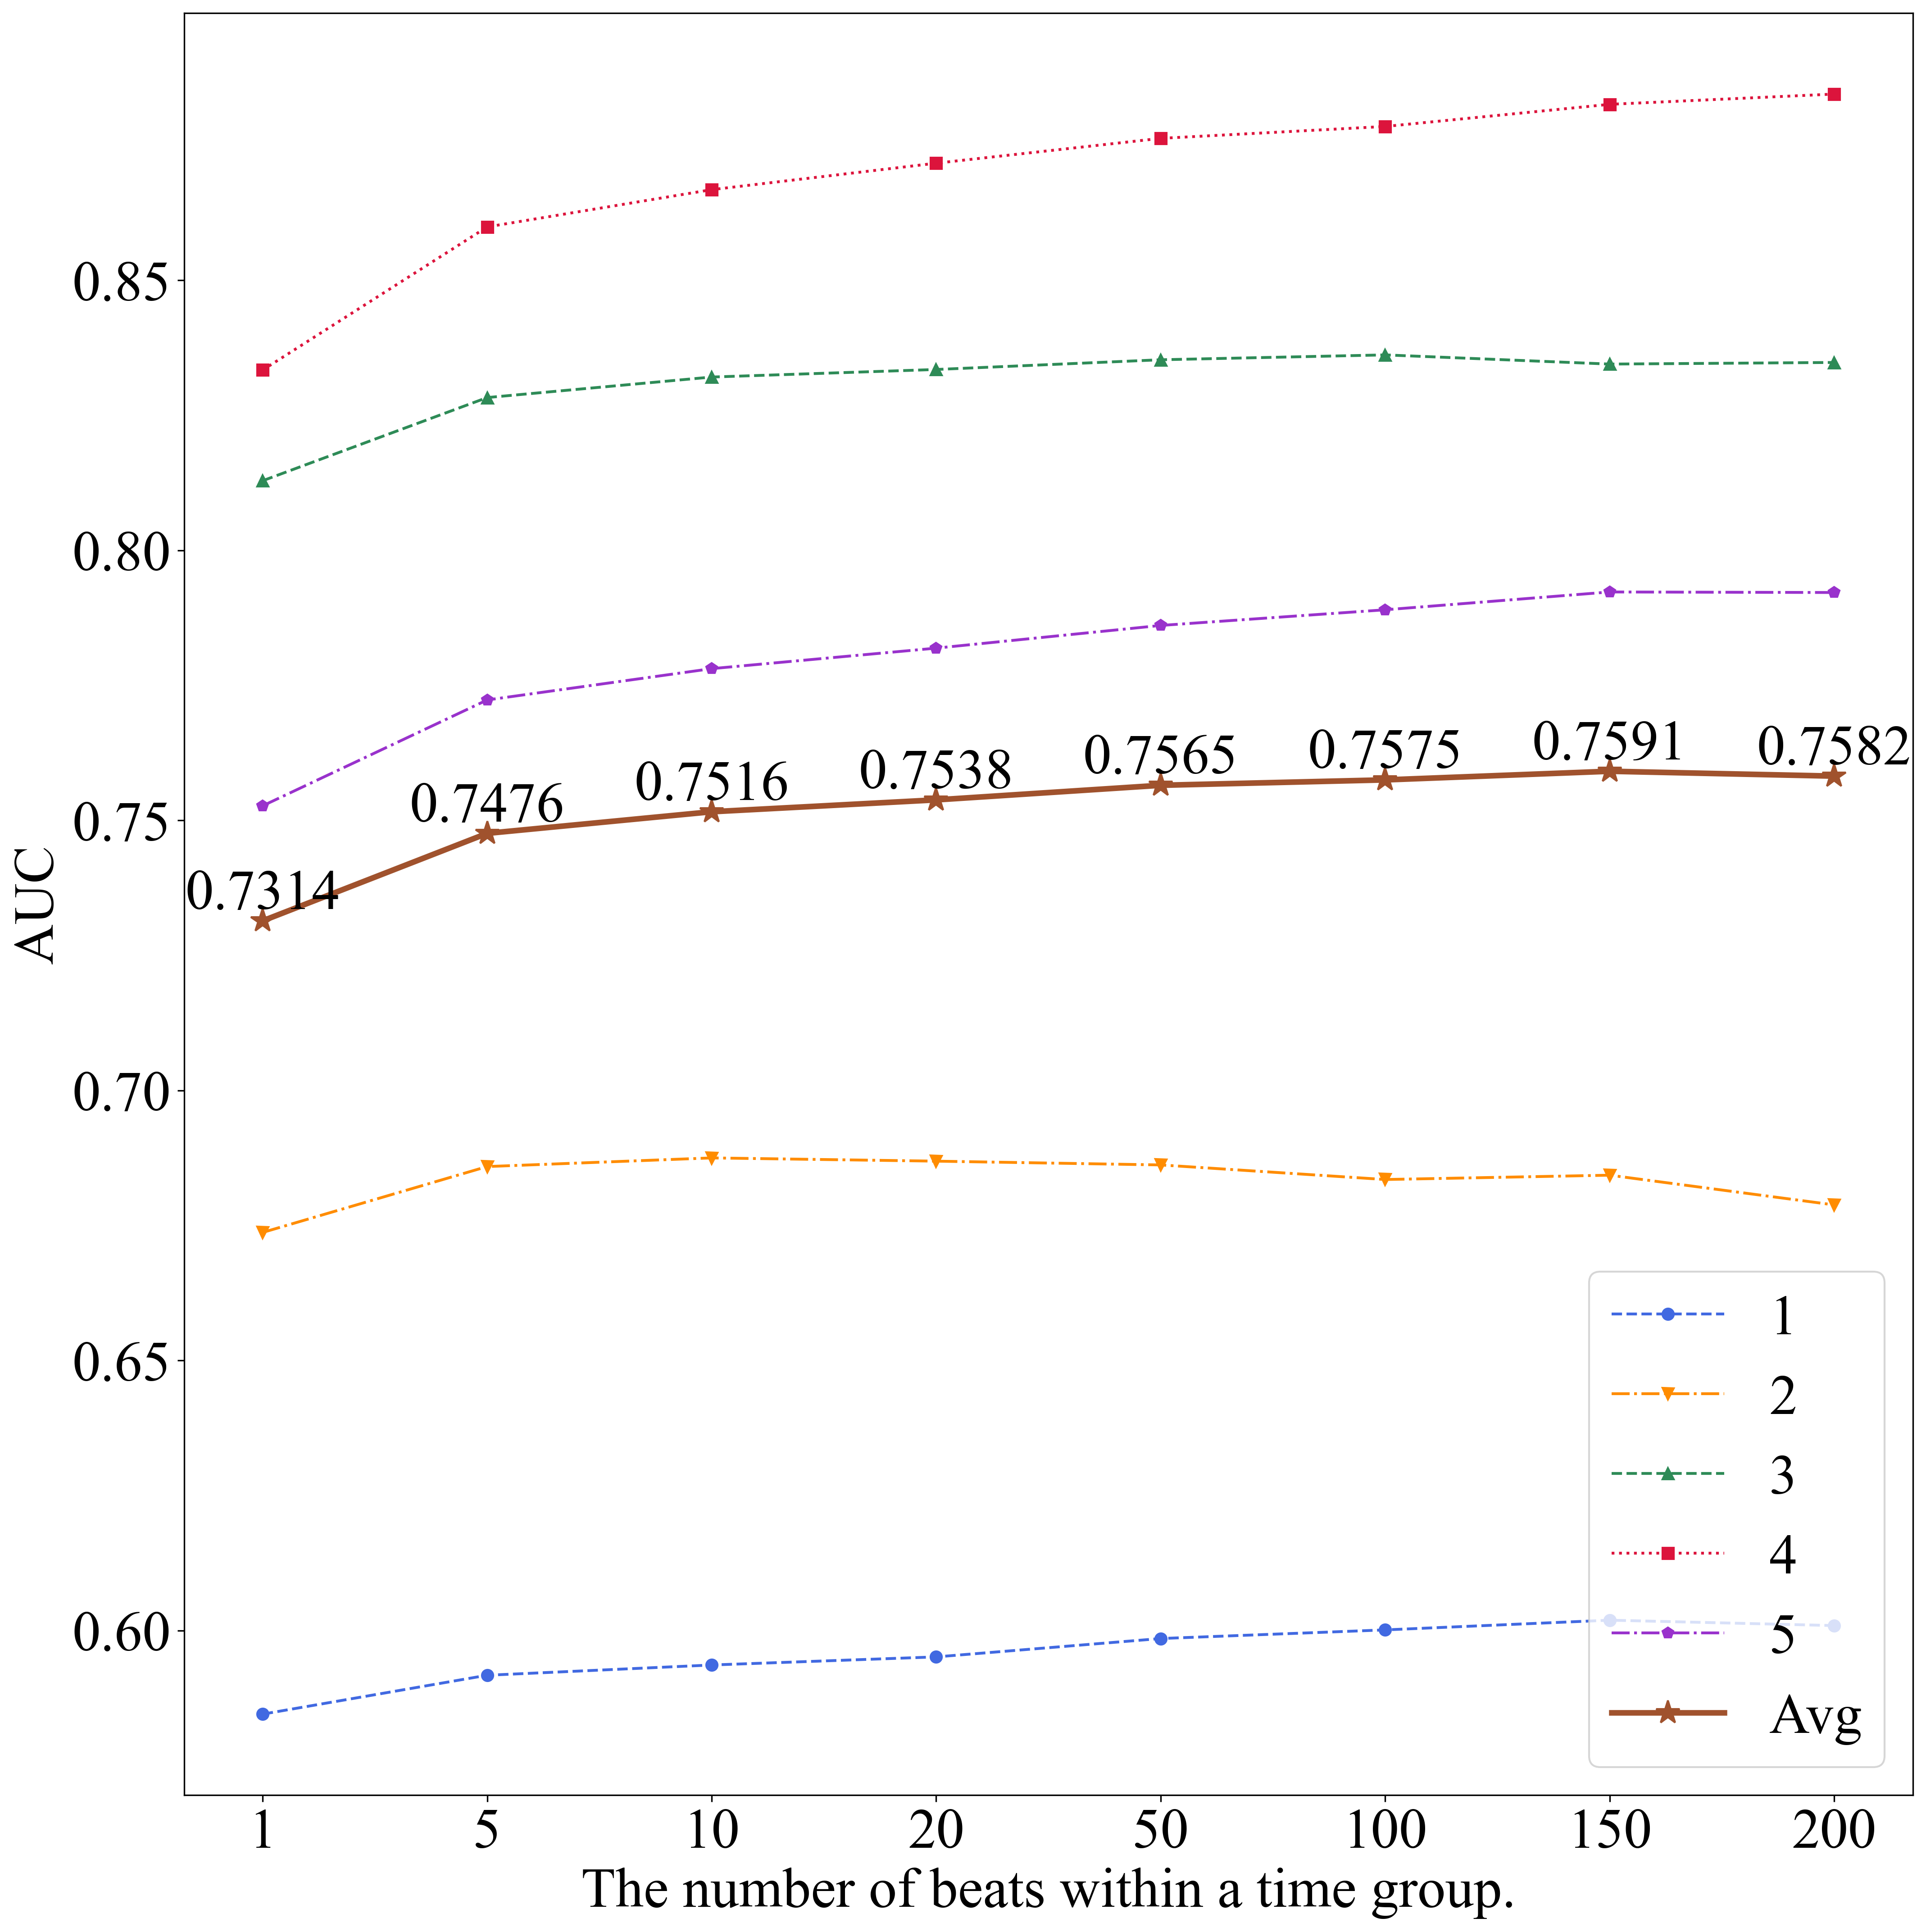

In [5]:
avgFilePath = f"./DenoiseResult/beatInforDecision/avg"
# 获取文件夹中所有以csv结尾的文件
csv_files = [f for f in os.listdir(avgFilePath) if f.endswith('.csv')]
# 定义提取数字的函数
def extract_number(file_name):
    # 从文件名中提取数字部分
    return int(''.join(filter(str.isdigit, file_name)))

# 按照数字部分进行排序
sorted_csv_files = sorted(csv_files, key=extract_number)

# 初始化图形
fig, ax = plt.subplots(figsize=(15, 15))

d = dict()
titles = []
indexValue = []
aucValue = []

for csv_file in sorted_csv_files:
    title = csv_file.split('.')[0][8:]
    titles.append(title)
    # 构造文件的完整路径
    file_path = os.path.join(avgFilePath, csv_file)
    # 读取csv文件为DataFrame
    df = pd.read_csv(file_path)
    # 提取index和auc列的值
    index_values = df['Index'].values
    auc_values = df['AUC'].values
    indexValue.append(index_values)
    aucValue.append(auc_values.tolist())
    d[title] = {"index": index_values, "auc": auc_values}
    # 绘制折线图
    # ax.plot(index_values, auc_values, label=csv_file)

# 绘制折线图
imagesX = []
imagesY = []
for i, key in enumerate(d.keys()):
    imagesX.append(key)
    imagesY.append(aucValue[i])

tempx = []
tempy = []
for i in range(len(imagesY[0])):
    tempx.append(imagesX)
    Y = []
    for j in range(len(imagesY)):
        Y.append(imagesY[j][i] * 0.01) # auc不用百分比表示
    tempy.append(Y)

colors = ['royalblue', 'darkorange', 'seagreen', 'crimson', 'darkorchid', 'sienna']
markers = ['o', 'v', '^', 's', 'p', '*']
line_styles = ['--', '-.', '--', ':', '-.', '-']
for i in range(len(tempx)):
    if indexValue[i][i] == 'Avg':
        ax.plot(tempx[i], tempy[i], label=indexValue[i][i], color=colors[i], marker=markers[i], linestyle=line_styles[i], linewidth=3, markersize=13)
        # 添加文本标签
        for x, y, val in zip(tempx[i], tempy[i], tempy[i]):
            ax.text(x, y, f'{val:.4f}', ha='center', va='bottom', color='black')
    else:
        ax.plot(tempx[i], tempy[i], label=indexValue[i][i], color=colors[i], marker=markers[i], linestyle=line_styles[i])

# ax.plot(imagesX, imagesY, label=indexValue[0])

# 设置图形标题和标签
# ax.set_title('AUC vs. Index')
ax.set_xlabel('The number of beats within a time group.')
ax.set_ylabel('AUC')

# 添加图例
ax.legend(
    [1,2,3,4,5,'Avg'],
           loc='lower right')
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig(f"./DenoiseResult/beatInforDecision/avg.eps", format="eps")
# plt.savefig(f"./DenoiseResult/beatInforDecision/compareAuc.png")